In [61]:
import pandas as pd
import json

def extract_director(crew_data):

    try:
        crew = json.loads(crew_data)
        for member in crew:
            if member.get('job') == 'Director':
                return member.get('name', '')
    except:
        return ''
    return ''

def concatenate_field(data, field, limit=None):

    try:
        items = json.loads(data)
        # Get list of field values
        field_values = [item[field] for item in items if field in item]

        # Limit the number of keywords if specified
        if limit:
            field_values = field_values[:limit]

        return ' '.join(field_values)
    except:
        return ''

def merge_movie_datasets(df1_path, df2_path):

    df1 = pd.read_csv(df1_path)
    df2 = pd.read_csv(df2_path)

    df1 = df1.rename(columns={'movie_id': 'id'})

    merged_df = pd.merge(
        df2,
        df1[['id', 'cast', 'crew']],
        on='id',
        how='left'
    )


    merged_df['director'] = merged_df['crew'].apply(extract_director)


    merged_df['genres'] = merged_df['genres'].apply(lambda x: concatenate_field(x, 'name'))


    merged_df['keywords'] = merged_df['keywords'].apply(lambda x: concatenate_field(x, 'name', limit=5))

    merged_df['cast'] = merged_df['cast'].apply(lambda x: concatenate_field(x, 'name'))


    final_df = merged_df.reset_index()


    columns_order = [
        'index', 'budget', 'genres', 'homepage', 'id', 'keywords',
        'original_language', 'original_title', 'overview', 'popularity',
        'production_companies', 'production_countries', 'release_date',
        'revenue', 'runtime', 'spoken_languages', 'status', 'tagline',
        'title', 'vote_average', 'vote_count', 'cast', 'crew', 'director'
    ]

    final_df = final_df[columns_order]

    return final_df


def main():

    df1_path = 'tmdb_5000_credits.csv'
    df2_path = 'tmdb_5000_movies.csv'

    try:
        # Merge datasets
        final_dataset = merge_movie_datasets(df1_path, df2_path)

        # Save the final dataset
        final_dataset.to_csv('movies.csv', index=False)

        print("Datasets merged successfully!")
        print(f"Total number of movies: {len(final_dataset)}")
        print("\nFirst few rows of the merged dataset:")
        print(final_dataset.head())

    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()


Datasets merged successfully!
Total number of movies: 4803

First few rows of the merged dataset:
   index     budget                                    genres  \
0      0  237000000  Action Adventure Fantasy Science Fiction   
1      1  300000000                  Adventure Fantasy Action   
2      2  245000000                    Action Adventure Crime   
3      3  250000000               Action Crime Drama Thriller   
4      4  260000000          Action Adventure Science Fiction   

                                       homepage      id  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   
2   http://www.sonypictures.com/movies/spectre/  206647   
3            http://www.thedarkknightrises.com/   49026   
4          http://movies.disney.com/john-carter   49529   

                                            keywords original_language  \
0  culture clash future space war space colony so...                en   
1  ocean

Importing the dependencies

In [31]:
import numpy as np
import pandas as pd
import difflib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Data Collection and Pre-Processing

In [32]:
# loading the data from the csv file to apandas dataframe
movies_data = pd.read_csv('/content/movies.csv')

In [33]:
# printing the first 5 rows of the dataframe
movies_data.head()

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",James Cameron
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",Gore Verbinski
2,2,245000000,Action Adventure Crime,http://www.sonypictures.com/movies/spectre/,206647,spy based on novel secret agent sequel mi6,en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Daniel Craig Christoph Waltz Léa Seydoux Ralph...,"[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",Sam Mendes
3,3,250000000,Action Crime Drama Thriller,http://www.thedarkknightrises.com/,49026,dc comics crime fighter terrorist secret ident...,en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Christian Bale Michael Caine Gary Oldman Anne ...,"[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",Christopher Nolan
4,4,260000000,Action Adventure Science Fiction,http://movies.disney.com/john-carter,49529,based on novel mars medallion space travel pri...,en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,Taylor Kitsch Lynn Collins Samantha Morton Wil...,"[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",Andrew Stanton


In [34]:
# number of rows and columns in the data frame

movies_data.shape

(4803, 24)

In [35]:
# selecting the relevant features for recommendation

selected_features = ['genres','keywords','tagline','cast','director']
print(selected_features)

['genres', 'keywords', 'tagline', 'cast', 'director']


In [36]:
# replacing the null valuess with null string

for feature in selected_features:
  movies_data[feature] = movies_data[feature].fillna('')

In [37]:
# combining all the 5 selected features

combined_features = movies_data['genres']+' '+movies_data['keywords']+' '+movies_data['tagline']+' '+movies_data['cast']+' '+movies_data['director']

In [38]:
print(combined_features)

0       Action Adventure Fantasy Science Fiction cultu...
1       Adventure Fantasy Action ocean drug abuse exot...
2       Action Adventure Crime spy based on novel secr...
3       Action Crime Drama Thriller dc comics crime fi...
4       Action Adventure Science Fiction based on nove...
                              ...                        
4798    Action Crime Thriller united states–mexico bar...
4799    Comedy Romance  A newlywed couple's honeymoon ...
4800    Comedy Drama Romance TV Movie date love at fir...
4801      A New Yorker in Shanghai Daniel Henney Eliza...
4802    Documentary obsession camcorder crush dream gi...
Length: 4803, dtype: object


In [39]:
# converting the text data to feature vectors

vectorizer = TfidfVectorizer()

In [40]:
feature_vectors = vectorizer.fit_transform(combined_features)

In [41]:
print(feature_vectors)

  (0, 312)	0.027444403278887284
  (0, 464)	0.031510034990557725
  (0, 12331)	0.03864266432379152
  (0, 33398)	0.036095634779909
  (0, 12722)	0.036095634779909
  (0, 8731)	0.07472046406907248
  (0, 7514)	0.07678870422667931
  (0, 13591)	0.05751914774890932
  (0, 35288)	0.11830623610791505
  (0, 39775)	0.04383374876039391
  (0, 7842)	0.08718302797549855
  (0, 35033)	0.07472046406907248
  (0, 11738)	0.08391958713322474
  (0, 37321)	0.024662057382580815
  (0, 40673)	0.04478322327694058
  (0, 27761)	0.03158010262858953
  (0, 28499)	0.08718302797549855
  (0, 32710)	0.041724182821083027
  (0, 40689)	0.07605658475887479
  (0, 41509)	0.060509228025640474
  (0, 32637)	0.07244407285067829
  (0, 34531)	0.06750586185610603
  (0, 39925)	0.0603305800101749
  (0, 35778)	0.038800954071589774
  (0, 21279)	0.06892570185232937
  :	:
  (4801, 33969)	0.30716437154962506
  (4801, 34238)	0.3334791028703304
  (4801, 17197)	0.3334791028703304
  (4802, 24245)	0.11396793989647584
  (4802, 3969)	0.1088929903016180

# Exploratory Data Analysis

First 5 rows of the dataset:


,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",James Cameron
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",Gore Verbinski
2,2,245000000,Action Adventure Crime,http://www.sonypictures.com/movies/spectre/,206647,spy based on novel secret agent sequel mi6,en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Daniel Craig Christoph Waltz Léa Seydoux Ralph...,"[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",Sam Mendes
3,3,250000000,Action Crime Drama Thriller,http://www.thedarkknightrises.com/,49026,dc comics crime fighter terrorist secret ident...,en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Christian Bale Michael Caine Gary Oldman Anne ...,"[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",Christopher Nolan
4,4,260000000,Action Adventure Science Fiction,http://movies.disney.com/john-carter,49529,based on novel mars medallion space travel pri...,en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,Taylor Kitsch Lynn Collins Samantha Morton Wil...,"[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",Andrew Stanton



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 4803 non-null   int64  
 1   budget                4803 non-null   int64  
 2   genres                4775 non-null   object 
 3   homepage              1712 non-null   object 
 4   id                    4803 non-null   int64  
 5   keywords              4391 non-null   object 
 6   original_language     4803 non-null   object 
 7   original_title        4803 non-null   object 
 8   overview              4800 non-null   object 
 9   popularity            4803 non-null   float64
 10  production_companies  4803 non-null   object 
 11  production_countries  4803 non-null   object 
 12  release_date          4802 non-null   object 
 13  revenue               4803 non-null   int64  
 14  runtime               4801 non-null   float64
 15  spoken

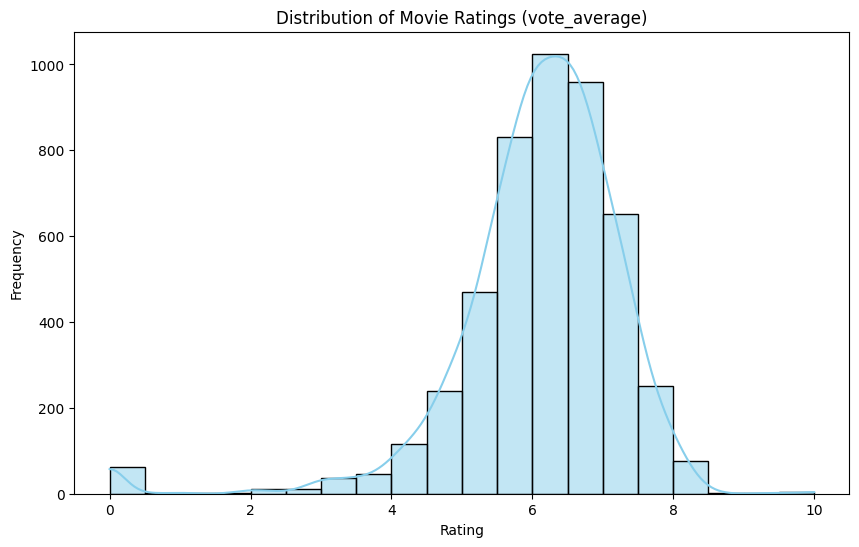

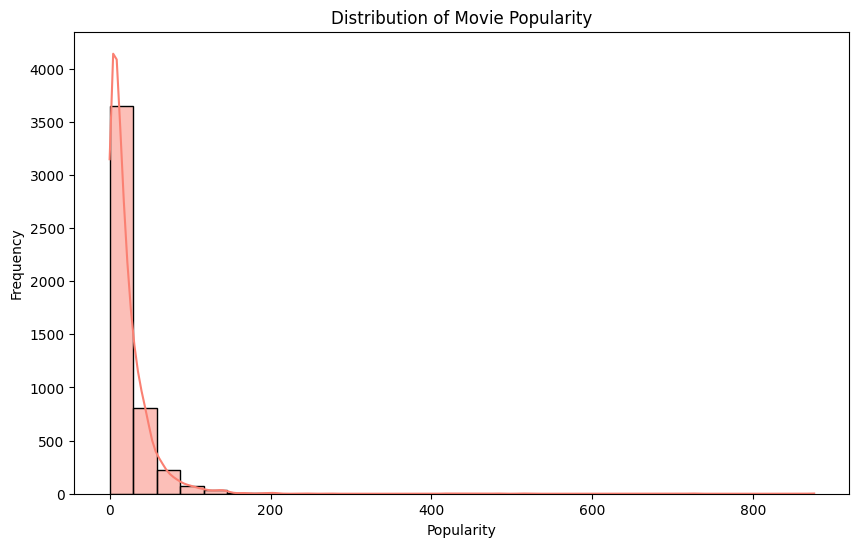

<ipython-input-42-a6a2dcc22e2b>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_genres.index, y=top_genres.values, palette='viridis')


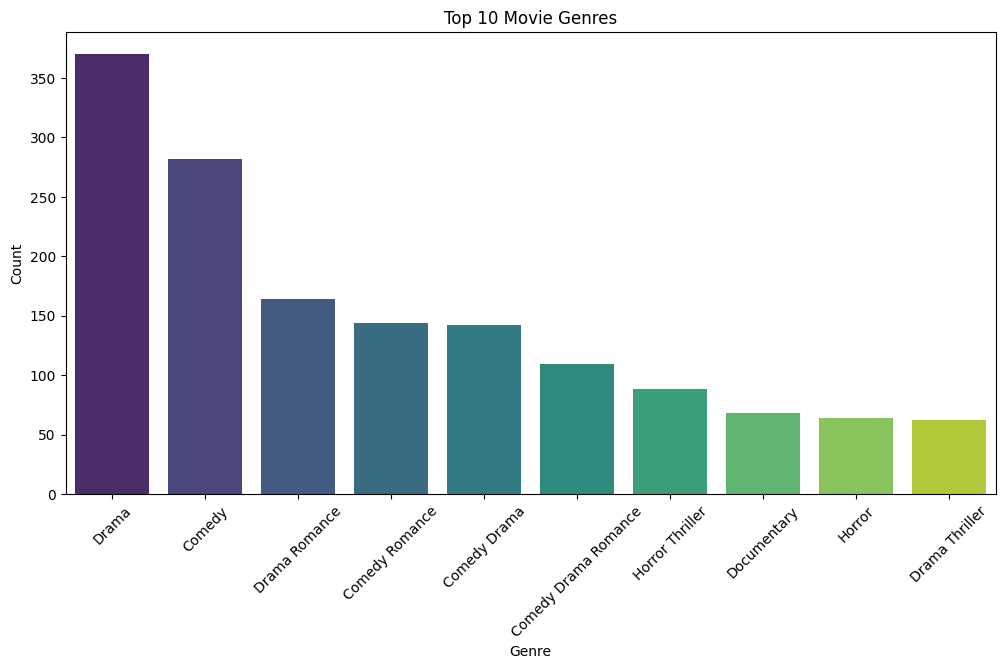

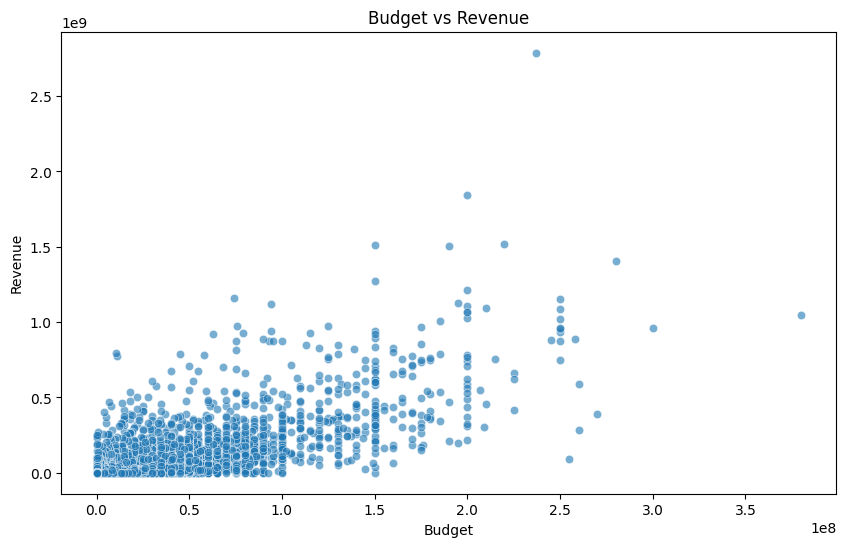

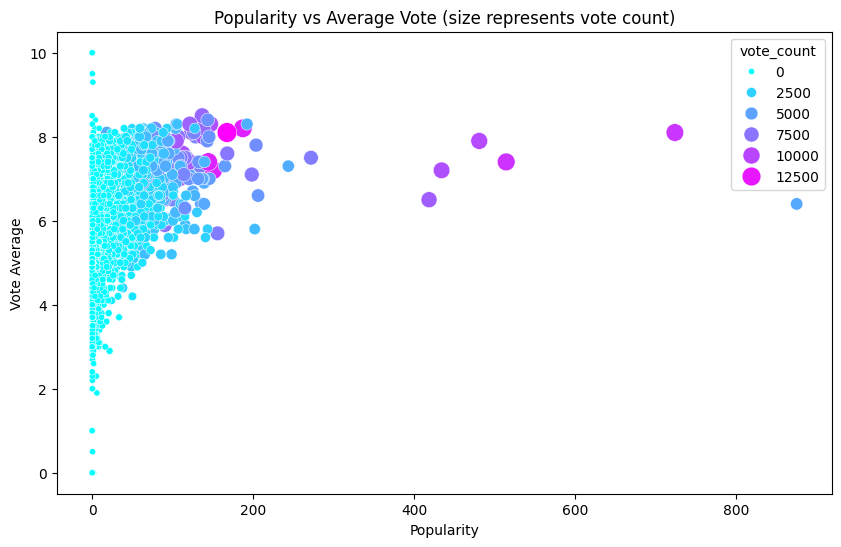

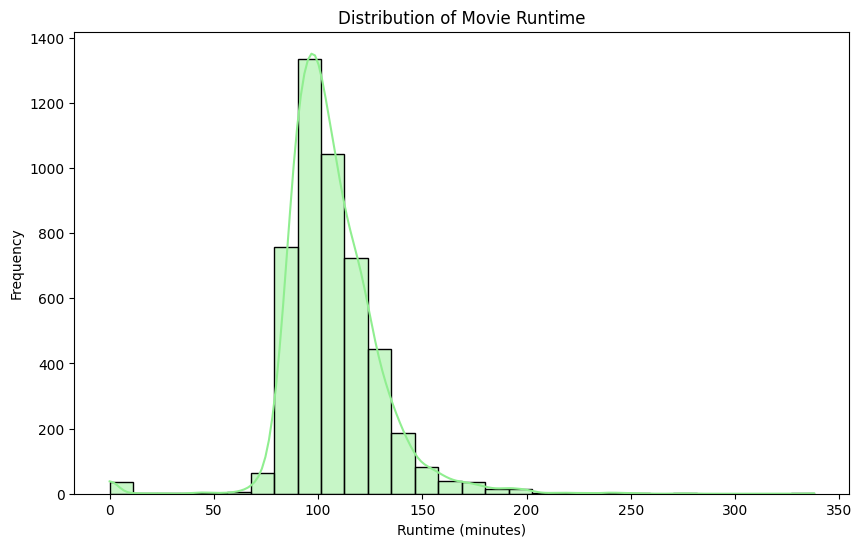

<ipython-input-42-a6a2dcc22e2b>:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_directors.index, y=top_directors.values, palette='magma')


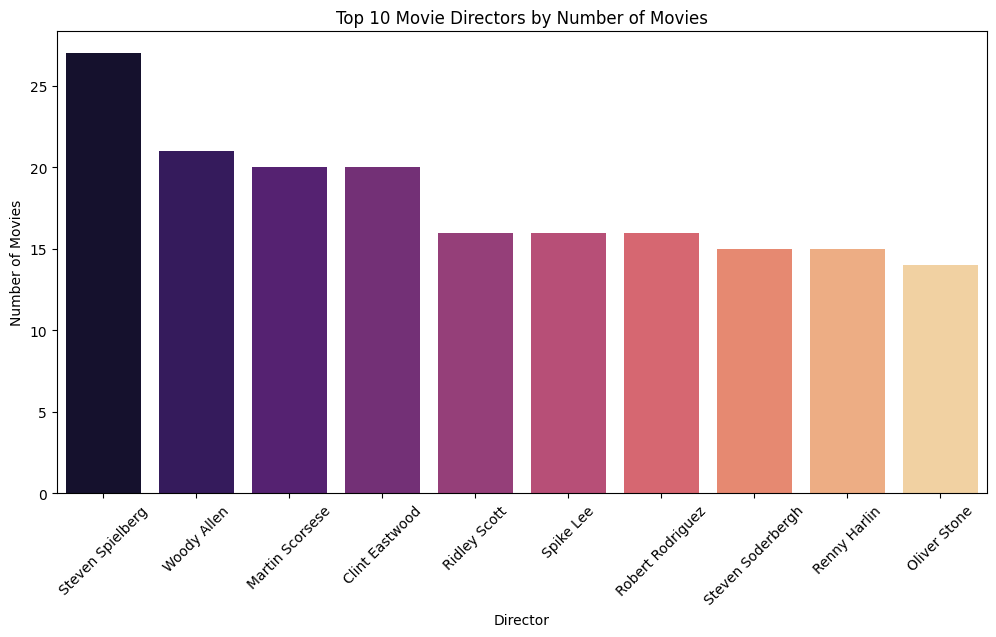

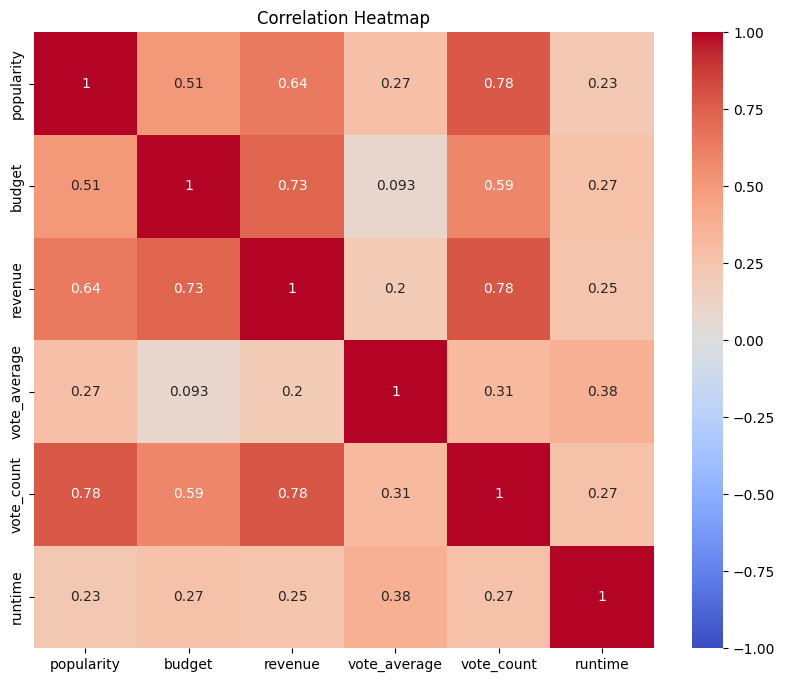

In [42]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the data from the CSV file into a pandas dataframe
movies_data = pd.read_csv('/content/movies.csv')

# Displaying the first few rows of the dataset
print("First 5 rows of the dataset:")
display(movies_data.head())

# Summary of dataset
print("\nDataset Info:")
movies_data.info()

# Checking for missing values
print("\nMissing Values:")
print(movies_data.isnull().sum())

# Basic statistics of numerical features
print("\nDescriptive Statistics for Numerical Features:")
print(movies_data.describe())

# Checking distribution of vote_average (movie ratings)
plt.figure(figsize=(10, 6))
sns.histplot(movies_data['vote_average'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Movie Ratings (vote_average)')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# Visualizing the popularity of movies
plt.figure(figsize=(10, 6))
sns.histplot(movies_data['popularity'], bins=30, kde=True, color='salmon')
plt.title('Distribution of Movie Popularity')
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.show()

# Top genres by count
# First, we'll split the genres and explode them into a single column for counting
movies_data['genres'] = movies_data['genres'].fillna('')  # Fill null values
movies_data['genres_split'] = movies_data['genres'].apply(lambda x: x.split('|'))
genres_exploded = movies_data.explode('genres_split')
top_genres = genres_exploded['genres_split'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_genres.index, y=top_genres.values, palette='viridis')
plt.title('Top 10 Movie Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Relationship between budget and revenue
plt.figure(figsize=(10, 6))
sns.scatterplot(data=movies_data, x='budget', y='revenue', alpha=0.6)
plt.title('Budget vs Revenue')
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.show()

# Popularity vs Vote Average
plt.figure(figsize=(10, 6))
sns.scatterplot(data=movies_data, x='popularity', y='vote_average', hue='vote_count', size='vote_count', palette='cool', sizes=(20, 200))
plt.title('Popularity vs Average Vote (size represents vote count)')
plt.xlabel('Popularity')
plt.ylabel('Vote Average')
plt.show()

# Distribution of movie runtime
plt.figure(figsize=(10, 6))
sns.histplot(movies_data['runtime'].dropna(), bins=30, kde=True, color='lightgreen')
plt.title('Distribution of Movie Runtime')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Frequency')
plt.show()

# Top 10 directors by number of movies
top_directors = movies_data['director'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_directors.index, y=top_directors.values, palette='magma')
plt.title('Top 10 Movie Directors by Number of Movies')
plt.xlabel('Director')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = movies_data[['popularity', 'budget', 'revenue', 'vote_average', 'vote_count', 'runtime']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()


# Cosine Similarity

In [43]:
# getting the similarity scores using cosine similarity

similarity = cosine_similarity(feature_vectors)

In [44]:
print(similarity)

[[1.         0.03047216 0.01478602 ... 0.00330417 0.02158332 0.00907849]
 [0.03047216 1.         0.02168148 ... 0.02517876 0.01730292 0.00631001]
 [0.01478602 0.02168148 1.         ... 0.00297315 0.00888519 0.        ]
 ...
 [0.00330417 0.02517876 0.00297315 ... 1.         0.         0.01408138]
 [0.02158332 0.01730292 0.00888519 ... 0.         1.         0.01386847]
 [0.00907849 0.00631001 0.         ... 0.01408138 0.01386847 1.        ]]


In [45]:
print(similarity.shape)

(4803, 4803)


Getting the movie name from the user

In [46]:
# getting the movie name from the user

movie_name = input(' Enter your favourite movie name : ')

 Enter your favourite movie name : avengers


In [47]:
# creating a list with all the movie names given in the dataset

list_of_all_titles = movies_data['title'].tolist()
print(list_of_all_titles)

['Avatar', "Pirates of the Caribbean: At World's End", 'Spectre', 'The Dark Knight Rises', 'John Carter', 'Spider-Man 3', 'Tangled', 'Avengers: Age of Ultron', 'Harry Potter and the Half-Blood Prince', 'Batman v Superman: Dawn of Justice', 'Superman Returns', 'Quantum of Solace', "Pirates of the Caribbean: Dead Man's Chest", 'The Lone Ranger', 'Man of Steel', 'The Chronicles of Narnia: Prince Caspian', 'The Avengers', 'Pirates of the Caribbean: On Stranger Tides', 'Men in Black 3', 'The Hobbit: The Battle of the Five Armies', 'The Amazing Spider-Man', 'Robin Hood', 'The Hobbit: The Desolation of Smaug', 'The Golden Compass', 'King Kong', 'Titanic', 'Captain America: Civil War', 'Battleship', 'Jurassic World', 'Skyfall', 'Spider-Man 2', 'Iron Man 3', 'Alice in Wonderland', 'X-Men: The Last Stand', 'Monsters University', 'Transformers: Revenge of the Fallen', 'Transformers: Age of Extinction', 'Oz: The Great and Powerful', 'The Amazing Spider-Man 2', 'TRON: Legacy', 'Cars 2', 'Green Lant

In [48]:
# finding the close match for the movie name given by the user

find_close_match = difflib.get_close_matches(movie_name, list_of_all_titles)
print(find_close_match)

['The Avengers', 'Savages', 'Swingers']


In [49]:
close_match = find_close_match[0]
print(close_match)

The Avengers


In [50]:
# finding the index of the movie with title

index_of_the_movie = movies_data[movies_data.title == close_match]['index'].values[0]
print(index_of_the_movie)

16


In [51]:
# getting a list of similar movies

similarity_score = list(enumerate(similarity[index_of_the_movie]))
print(similarity_score)

[(0, 0.04468650103003977), (1, 0.03558146134129063), (2, 0.012448451364146528), (3, 0.11302965318784428), (4, 0.03529718859449753), (5, 0.06900552760237519), (6, 0.012189339918856634), (7, 0.1555558883949711), (8, 0.04357828794557658), (9, 0.07938168275691097), (10, 0.030897014840527662), (11, 0.013519141080597857), (12, 0.04018447928229274), (13, 0.017902722479705365), (14, 0.06366203375101359), (15, 0.02335237526041229), (16, 1.0), (17, 0.017723844398345893), (18, 0.028263475171391054), (19, 0.040236308334511445), (20, 0.04741898983652239), (21, 0.029030132038228962), (22, 0.028986803832037333), (23, 0.03806047858087863), (24, 0.04109972447993206), (25, 0.04278045618556731), (26, 0.09387041597686555), (27, 0.03058582328806006), (28, 0.036240152289377506), (29, 0.014498704052737642), (30, 0.0592350232310364), (31, 0.09496371884583699), (32, 0.026333912653991823), (33, 0.06578562887119112), (34, 0.008011892897270168), (35, 0.04663273979418624), (36, 0.03691565079704835), (37, 0.0548414

In [52]:
len(similarity_score)

4803

In [53]:
# sorting the movies based on their similarity score

sorted_similar_movies = sorted(similarity_score, key = lambda x:x[1], reverse = True)
print(sorted_similar_movies)

[(16, 1.0), (129, 0.15817148121056016), (7, 0.1555558883949711), (85, 0.13955360814819595), (3, 0.11302965318784428), (79, 0.1079059905139864), (126, 0.10076039338184892), (31, 0.09496371884583699), (26, 0.09387041597686555), (1177, 0.08956033089161436), (158, 0.08682341627085874), (174, 0.08628463900171193), (511, 0.0859321104609837), (68, 0.08532105281098738), (883, 0.08272828705315821), (218, 0.08170729078261833), (9, 0.07938168275691097), (365, 0.07837628799378993), (182, 0.0778423148723205), (4216, 0.07741620017189182), (38, 0.0768895812376925), (165, 0.07684504956603613), (655, 0.07652229801871882), (813, 0.07554424936517985), (782, 0.07520499131547857), (1424, 0.07327573925958228), (46, 0.07319625503888842), (3163, 0.07170346434710755), (669, 0.07129950438542185), (1847, 0.07125302667880104), (2912, 0.06908712709445045), (5, 0.06900552760237519), (64, 0.06858161826906027), (1740, 0.0680581934815518), (1502, 0.06805270480773754), (1165, 0.06750177393225285), (94, 0.06744631629850

In [54]:
# print the name of similar movies based on the index

print('Movies suggested for you : \n')

i = 1

for movie in sorted_similar_movies:
  index = movie[0]
  title_from_index = movies_data[movies_data.index==index]['title'].values[0]
  if (i<30):
    print(i, '.',title_from_index)
    i+=1

Movies suggested for you : 

1 . The Avengers
2 . Thor
3 . Avengers: Age of Ultron
4 . Captain America: The Winter Soldier
5 . The Dark Knight Rises
6 . Iron Man 2
7 . Thor: The Dark World
8 . Iron Man 3
9 . Captain America: Civil War
10 . Sin City
11 . Star Trek
12 . The Incredible Hulk
13 . X-Men
14 . Iron Man
15 . Catch Me If You Can
16 . Jason Bourne
17 . Batman v Superman: Dawn of Justice
18 . Contact
19 . Ant-Man
20 . Mr. Smith Goes to Washington
21 . The Amazing Spider-Man 2
22 . Hulk
23 . Red Dawn
24 . Superman
25 . The Spirit
26 . Concussion
27 . X-Men: Days of Future Past
28 . Detention
29 . Sin City: A Dame to Kill For


Movie Recommendation Sytem

In [55]:
movie_name = input(' Enter your favourite movie name : ')

list_of_all_titles = movies_data['title'].tolist()

find_close_match = difflib.get_close_matches(movie_name, list_of_all_titles)

close_match = find_close_match[0]

index_of_the_movie = movies_data[movies_data.title == close_match]['index'].values[0]

similarity_score = list(enumerate(similarity[index_of_the_movie]))

sorted_similar_movies = sorted(similarity_score, key = lambda x:x[1], reverse = True)

print('Movies suggested for you : \n')

i = 1

for movie in sorted_similar_movies:
  index = movie[0]
  title_from_index = movies_data[movies_data.index==index]['title'].values[0]
  if (i<30):
    print(i, '.',title_from_index)
    i+=1

 Enter your favourite movie name : avengers
Movies suggested for you : 

1 . The Avengers
2 . Thor
3 . Avengers: Age of Ultron
4 . Captain America: The Winter Soldier
5 . The Dark Knight Rises
6 . Iron Man 2
7 . Thor: The Dark World
8 . Iron Man 3
9 . Captain America: Civil War
10 . Sin City
11 . Star Trek
12 . The Incredible Hulk
13 . X-Men
14 . Iron Man
15 . Catch Me If You Can
16 . Jason Bourne
17 . Batman v Superman: Dawn of Justice
18 . Contact
19 . Ant-Man
20 . Mr. Smith Goes to Washington
21 . The Amazing Spider-Man 2
22 . Hulk
23 . Red Dawn
24 . Superman
25 . The Spirit
26 . Concussion
27 . X-Men: Days of Future Past
28 . Detention
29 . Sin City: A Dame to Kill For


In [74]:
import numpy as np
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity

class TFIDFEvaluator:
    def __init__(self, feature_vectors, movies_data):
        self.feature_vectors = feature_vectors
        self.movies_data = movies_data

    def compute_sparsity(self):
        if sparse.issparse(self.feature_vectors):
            total_elements = self.feature_vectors.shape[0] * self.feature_vectors.shape[1]
            non_zero = self.feature_vectors.nnz
            return 1.0 - (non_zero / total_elements)
        else:
            non_zero = np.count_nonzero(self.feature_vectors)
            total_elements = self.feature_vectors.size
            return 1.0 - (non_zero / total_elements)

    def compute_diversity(self):
        if sparse.issparse(self.feature_vectors):
            unique_terms = len(np.unique(self.feature_vectors.nonzero()[1]))
            return unique_terms / self.feature_vectors.shape[1]
        else:
            unique_terms = len(np.unique(np.nonzero(self.feature_vectors)[1]))
            return unique_terms / self.feature_vectors.shape[1]

    def compute_similarity_stats(self):
        # Convert to dense if sparse
        vectors = self.feature_vectors.toarray() if sparse.issparse(self.feature_vectors) else self.feature_vectors

        # Compute pairwise similarities
        similarities = cosine_similarity(vectors)
        # Set diagonal to 0 to exclude self-similarity
        np.fill_diagonal(similarities, 0)

        return {
            'mean_similarity': np.mean(similarities),
            'max_similarity': np.max(similarities),
            'min_similarity': np.min(similarities[similarities > 0])  # Exclude zeros
        }

    def print_evaluation_report(self):
        print("TF-IDF Vectorization Evaluation Report")
        print("=" * 50)
        print("\n1. Vector Quality Metrics:")
        print("-" * 30)

        # Compute basic statistics
        sparsity = self.compute_sparsity()
        diversity = self.compute_diversity()
        similarity_stats = self.compute_similarity_stats()

        print(f"Sparsity: {sparsity:.2%}")
        print(f"Feature Diversity: {diversity:.2%}")
        print(f"\nDocument Similarity Statistics:")
        print(f"- Mean Similarity: {similarity_stats['mean_similarity']:.3f}")
        print(f"- Max Similarity: {similarity_stats['max_similarity']:.3f}")
        print(f"- Min Similarity: {similarity_stats['min_similarity']:.3f}")

        # Shape information
        print(f"\n2. Matrix Dimensions:")
        print("-" * 30)
        print(f"Number of documents: {self.feature_vectors.shape[0]}")
        print(f"Number of features: {self.feature_vectors.shape[1]}")

# Example usage:
evaluator = TFIDFEvaluator(feature_vectors, movies_data)
evaluator.print_evaluation_report()

TF-IDF Vectorization Evaluation Report

1. Vector Quality Metrics:
------------------------------
Sparsity: 99.86%
Feature Diversity: 100.00%

Document Similarity Statistics:
- Mean Similarity: 0.013
- Max Similarity: 0.830
- Min Similarity: 0.000

2. Matrix Dimensions:
------------------------------
Number of documents: 4803
Number of features: 41698


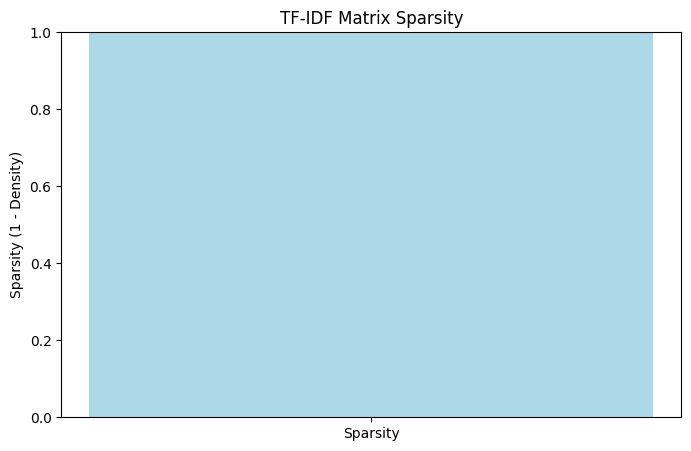

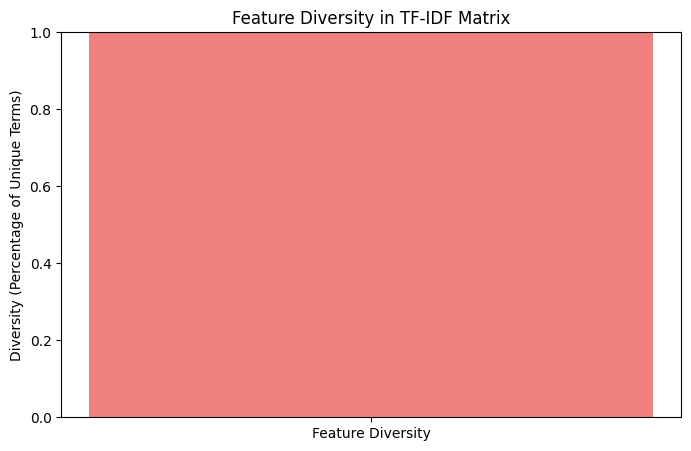

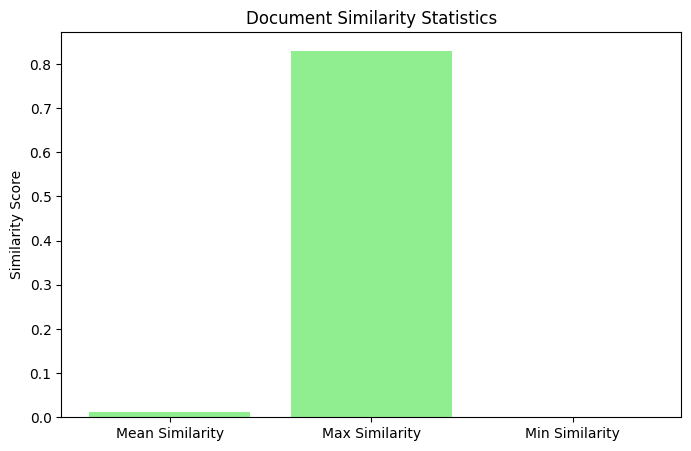

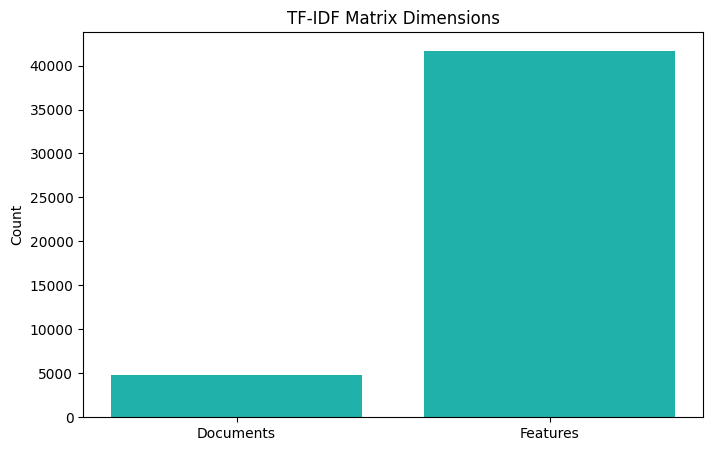

In [94]:
import matplotlib.pyplot as plt

class TFIDFEvaluator:
    def __init__(self, feature_vectors, movies_data):
        self.feature_vectors = feature_vectors
        self.movies_data = movies_data

    def compute_sparsity(self):
        if sparse.issparse(self.feature_vectors):
            total_elements = self.feature_vectors.shape[0] * self.feature_vectors.shape[1]
            non_zero = self.feature_vectors.nnz
            return 1.0 - (non_zero / total_elements)
        else:
            non_zero = np.count_nonzero(self.feature_vectors)
            total_elements = self.feature_vectors.size
            return 1.0 - (non_zero / total_elements)

    def compute_diversity(self):
        if sparse.issparse(self.feature_vectors):
            unique_terms = len(np.unique(self.feature_vectors.nonzero()[1]))
            return unique_terms / self.feature_vectors.shape[1]
        else:
            unique_terms = len(np.unique(np.nonzero(self.feature_vectors)[1]))
            return unique_terms / self.feature_vectors.shape[1]

    def compute_similarity_stats(self):
        # Convert to dense if sparse
        vectors = self.feature_vectors.toarray() if sparse.issparse(self.feature_vectors) else self.feature_vectors

        # Compute pairwise similarities
        similarities = cosine_similarity(vectors)
        # Set diagonal to 0 to exclude self-similarity
        np.fill_diagonal(similarities, 0)

        return {
            'mean_similarity': np.mean(similarities),
            'max_similarity': np.max(similarities),
            'min_similarity': np.min(similarities[similarities > 0])  # Exclude zeros
        }

    def plot_evaluation_report(self):
        # Sparsity Plot
        sparsity = self.compute_sparsity()
        plt.figure(figsize=(8, 5))
        plt.bar(['Sparsity'], [sparsity], color='lightblue')
        plt.title("TF-IDF Matrix Sparsity")
        plt.ylabel("Sparsity (1 - Density)")
        plt.ylim(0, 1)
        plt.show()

        # Feature Diversity Plot
        diversity = self.compute_diversity()
        plt.figure(figsize=(8, 5))
        plt.bar(['Feature Diversity'], [diversity], color='lightcoral')
        plt.title("Feature Diversity in TF-IDF Matrix")
        plt.ylabel("Diversity (Percentage of Unique Terms)")
        plt.ylim(0, 1)
        plt.show()

        # Similarity Statistics Plot
        sim_stats = self.compute_similarity_stats()
        similarity_values = [sim_stats['mean_similarity'], sim_stats['max_similarity'], sim_stats['min_similarity']]
        similarity_labels = ['Mean Similarity', 'Max Similarity', 'Min Similarity']

        plt.figure(figsize=(8, 5))
        plt.bar(similarity_labels, similarity_values, color='lightgreen')
        plt.title("Document Similarity Statistics")
        plt.ylabel("Similarity Score")
        plt.show()

        # Matrix Dimensions Plot
        num_documents = self.feature_vectors.shape[0]
        num_features = self.feature_vectors.shape[1]

        plt.figure(figsize=(8, 5))
        plt.bar(['Documents', 'Features'], [num_documents, num_features], color='lightseagreen')
        plt.title("TF-IDF Matrix Dimensions")
        plt.ylabel("Count")
        plt.show()

# Example usage:
evaluator = TFIDFEvaluator(feature_vectors, movies_data)
evaluator.plot_evaluation_report()


# 2. KNN Algorithm


In [69]:
# Importing dependencies
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

# Loading the data from the CSV file to a pandas dataframe
movies_data = pd.read_csv('/content/movies.csv')

# Selecting the relevant features for recommendation
selected_features = ['genres', 'keywords', 'tagline', 'cast', 'director']

# Replacing null values with an empty string
for feature in selected_features:
    movies_data[feature] = movies_data[feature].fillna('')

# Combining all the selected features
combined_features = movies_data['genres'] + ' ' + movies_data['keywords'] + ' ' + movies_data['tagline'] + ' ' + movies_data['cast'] + ' ' + movies_data['director']

# Converting the text data to feature vectors
vectorizer = TfidfVectorizer()
feature_vectors = vectorizer.fit_transform(combined_features)

# Setting up the KNN model using cosine similarity
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(feature_vectors)

# Function to get movie recommendations
def get_movie_recommendations(movie_name, num_recommendations=10):
    # Creating a list with all the movie titles in the dataset
    list_of_all_titles = movies_data['title'].tolist()

    # Finding the closest match for the movie name given by the user
    close_match = difflib.get_close_matches(movie_name, list_of_all_titles, n=1)

    if not close_match:
        return "Sorry, we couldn't find a match for your movie."

    # Getting the index of the matched movie title
    close_match = close_match[0]
    movie_index = movies_data[movies_data.title == close_match].index[0]

    # Getting distances and indices of the K-nearest neighbors
    distances, indices = knn_model.kneighbors(feature_vectors[movie_index], n_neighbors=num_recommendations + 1)

    # Displaying the recommended movies
    print(f"Movies recommended for you based on '{close_match}':\n")
    recommended_movies = []

    for i in range(1, len(distances.flatten())):
        index = indices.flatten()[i]
        recommended_movies.append(movies_data['title'][index])

    return recommended_movies

# Example usage:
movie_name = input("Enter your favorite movie name: ")
recommended_movies = get_movie_recommendations(movie_name)

if isinstance(recommended_movies, list):
    for i, title in enumerate(recommended_movies, start=1):
        print(f"{i}. {title}")
else:
    print(recommended_movies)


Enter your favorite movie name: avengers
Movies recommended for you based on 'The Avengers':

1. Thor
2. Avengers: Age of Ultron
3. Captain America: The Winter Soldier
4. The Dark Knight Rises
5. Iron Man 2
6. Thor: The Dark World
7. Iron Man 3
8. Captain America: Civil War
9. Sin City
10. Star Trek


In [75]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict

class KNNRecommenderEvaluator:
    def __init__(self, knn_model, feature_vectors, movies_data):
        self.knn_model = knn_model
        self.feature_vectors = feature_vectors
        self.movies_data = movies_data

    def evaluate_coverage(self, k=10):
        """Evaluate what percentage of movies appear in recommendations"""
        total_movies = len(self.movies_data)
        recommended_movies = set()

        for idx in range(total_movies):
            _, indices = self.knn_model.kneighbors(self.feature_vectors[idx], n_neighbors=k+1)
            recommended_movies.update(indices.flatten())

        coverage = len(recommended_movies) / total_movies
        return coverage

    def evaluate_genre_diversity(self, k=10):
        """Evaluate genre diversity in recommendations"""
        total_recommendations = 0
        genre_combinations = defaultdict(int)

        for idx in range(len(self.movies_data)):
            _, indices = self.knn_model.kneighbors(self.feature_vectors[idx], n_neighbors=k+1)
            for rec_idx in indices[0][1:]:  # Skip the first one as it's the movie itself
                genres = self.movies_data.iloc[rec_idx]['genres']
                genre_combinations[genres] += 1
                total_recommendations += 1

        genre_diversity = len(genre_combinations) / total_recommendations
        return genre_diversity

    def evaluate_similarity_distribution(self, k=10):
        """Evaluate distribution of similarity scores"""
        similarities = []

        for idx in range(len(self.movies_data)):
            distances, _ = self.knn_model.kneighbors(self.feature_vectors[idx], n_neighbors=k+1)
            # Convert distances to similarities (1 - distance)
            similarities.extend(1 - distances.flatten()[1:])  # Skip the first one (self-similarity)

        return {
            'mean_similarity': np.mean(similarities),
            'std_similarity': np.std(similarities),
            'min_similarity': np.min(similarities),
            'max_similarity': np.max(similarities)
        }

    def print_evaluation_report(self, k=10):
        print("\nKNN Movie Recommender Evaluation Report")
        print("======================================")

        # Coverage Analysis
        coverage = self.evaluate_coverage(k)
        print(f"\n1. Coverage Analysis:")
        print(f"   - Recommendation coverage: {coverage:.2%}")

        # Genre Diversity
        genre_diversity = self.evaluate_genre_diversity(k)
        print(f"\n2. Genre Diversity:")
        print(f"   - Genre diversity score: {genre_diversity:.3f}")

        # Similarity Distribution
        sim_stats = self.evaluate_similarity_distribution(k)
        print(f"\n3. Similarity Distribution:")
        print(f"   - Mean similarity: {sim_stats['mean_similarity']:.3f}")
        print(f"   - Std deviation: {sim_stats['std_similarity']:.3f}")
        print(f"   - Min similarity: {sim_stats['min_similarity']:.3f}")
        print(f"   - Max similarity: {sim_stats['max_similarity']:.3f}")

        print("\n4. Model Parameters:")
        print(f"   - Number of neighbors (k): {k}")
        print(f"   - Total movies in dataset: {len(self.movies_data)}")
        print(f"   - Feature vector dimension: {self.feature_vectors.shape[1]}")

# Example usage:
evaluator = KNNRecommenderEvaluator(knn_model, feature_vectors, movies_data)
evaluator.print_evaluation_report()


KNN Movie Recommender Evaluation Report

1. Coverage Analysis:
   - Recommendation coverage: 99.73%

2. Genre Diversity:
   - Genre diversity score: 0.024

3. Similarity Distribution:
   - Mean similarity: 0.104
   - Std deviation: 0.046
   - Min similarity: 0.000
   - Max similarity: 0.830

4. Model Parameters:
   - Number of neighbors (k): 10
   - Total movies in dataset: 4803
   - Feature vector dimension: 41698


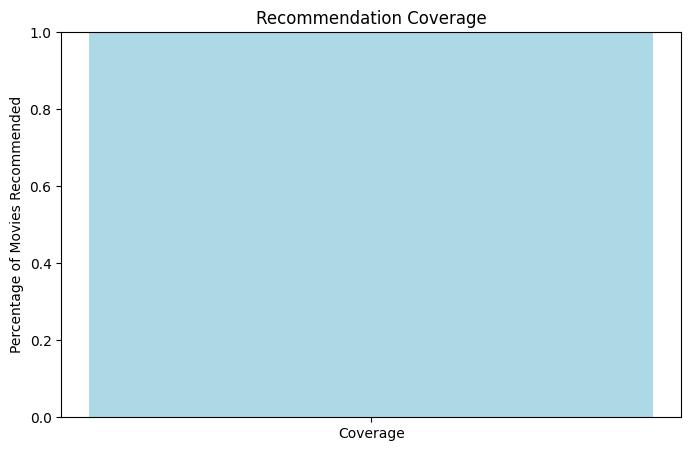

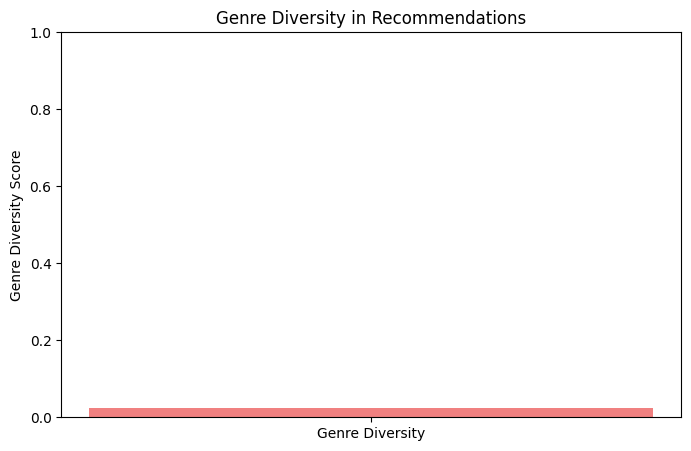

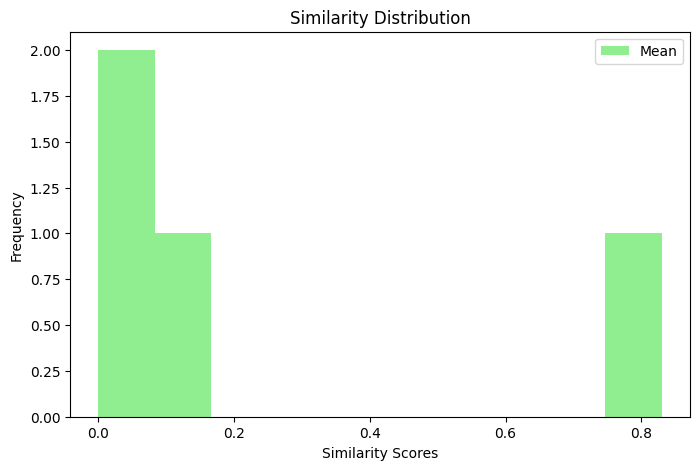

In [93]:
import matplotlib.pyplot as plt

class KNNRecommenderEvaluator:
    def __init__(self, knn_model, feature_vectors, movies_data):
        self.knn_model = knn_model
        self.feature_vectors = feature_vectors
        self.movies_data = movies_data

    def evaluate_coverage(self, k=10):
        """Evaluate what percentage of movies appear in recommendations"""
        total_movies = len(self.movies_data)
        recommended_movies = set()

        for idx in range(total_movies):
            _, indices = self.knn_model.kneighbors(self.feature_vectors[idx], n_neighbors=k+1)
            recommended_movies.update(indices.flatten())

        coverage = len(recommended_movies) / total_movies
        return coverage

    def evaluate_genre_diversity(self, k=10):
        """Evaluate genre diversity in recommendations"""
        total_recommendations = 0
        genre_combinations = defaultdict(int)

        for idx in range(len(self.movies_data)):
            _, indices = self.knn_model.kneighbors(self.feature_vectors[idx], n_neighbors=k+1)
            for rec_idx in indices[0][1:]:  # Skip the first one as it's the movie itself
                genres = self.movies_data.iloc[rec_idx]['genres']
                genre_combinations[genres] += 1
                total_recommendations += 1

        genre_diversity = len(genre_combinations) / total_recommendations
        return genre_diversity

    def evaluate_similarity_distribution(self, k=10):
        """Evaluate distribution of similarity scores"""
        similarities = []

        for idx in range(len(self.movies_data)):
            distances, _ = self.knn_model.kneighbors(self.feature_vectors[idx], n_neighbors=k+1)
            # Convert distances to similarities (1 - distance)
            similarities.extend(1 - distances.flatten()[1:])  # Skip the first one (self-similarity)

        return {
            'mean_similarity': np.mean(similarities),
            'std_similarity': np.std(similarities),
            'min_similarity': np.min(similarities),
            'max_similarity': np.max(similarities)
        }

    def plot_evaluation_report(self, k=10):
        # Coverage Plot
        coverage = self.evaluate_coverage(k)
        plt.figure(figsize=(8, 5))
        plt.bar(['Coverage'], [coverage], color='lightblue')
        plt.title("Recommendation Coverage")
        plt.ylabel("Percentage of Movies Recommended")
        plt.ylim(0, 1)
        plt.show()

        # Genre Diversity Plot
        genre_diversity = self.evaluate_genre_diversity(k)
        plt.figure(figsize=(8, 5))
        plt.bar(['Genre Diversity'], [genre_diversity], color='lightcoral')
        plt.title("Genre Diversity in Recommendations")
        plt.ylabel("Genre Diversity Score")
        plt.ylim(0, 1)
        plt.show()

        # Similarity Distribution Plot
        sim_stats = self.evaluate_similarity_distribution(k)
        plt.figure(figsize=(8, 5))
        plt.hist([sim_stats['mean_similarity'], sim_stats['std_similarity'], sim_stats['min_similarity'], sim_stats['max_similarity']],
                 bins=10, color='lightgreen', label=['Mean', 'Std Dev', 'Min', 'Max'])
        plt.title("Similarity Distribution")
        plt.xlabel("Similarity Scores")
        plt.ylabel("Frequency")
        plt.legend()
        plt.show()

# Example usage:
evaluator = KNNRecommenderEvaluator(knn_model, feature_vectors, movies_data)
evaluator.plot_evaluation_report()


# Random Forest

In [59]:
# Importing dependencies
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Loading the data from the CSV file to a pandas dataframe
movies_data = pd.read_csv('/content/movies.csv')

# Selecting the relevant features for recommendation
selected_features = ['genres', 'keywords', 'tagline', 'cast', 'director']

# Replacing null values with an empty string
for feature in selected_features:
    movies_data[feature] = movies_data[feature].fillna('')

# Combining all the selected features into a single 'tags' column
movies_data['tags'] = movies_data['genres'] + ' ' + movies_data['keywords'] + ' ' + movies_data['tagline'] + ' ' + movies_data['cast'] + ' ' + movies_data['director']

# Selecting numeric features for score prediction
numeric_features = ['popularity', 'budget', 'runtime', 'vote_count', 'revenue']

# Ensuring no NaN values in numeric columns
movies_data[numeric_features] = movies_data[numeric_features].fillna(0)

# Splitting the dataset into training and testing sets for prediction
X_train, X_test, y_train, y_test = train_test_split(movies_data[numeric_features], movies_data['vote_average'], test_size=0.3, random_state=42)

# Initializing the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Training the model on the numeric features to predict movie scores
rf_model.fit(X_train, y_train)

# Checking model score on test data
print("Random Forest Regressor Test Score:", rf_model.score(X_test, y_test))

# Converting the 'tags' text data to feature vectors for similarity matching
vectorizer = TfidfVectorizer()
feature_vectors = vectorizer.fit_transform(movies_data['tags'])

# Calculating cosine similarity based on the feature vectors
similarity = cosine_similarity(feature_vectors)

# Function to recommend movies based on a Random Forest score and cosine similarity
def get_movie_recommendations(movie_name, num_recommendations=10):
    # List of all movie titles
    list_of_all_titles = movies_data['title'].tolist()

    # Finding the closest match for the given movie title
    close_match = difflib.get_close_matches(movie_name, list_of_all_titles, n=1)

    if not close_match:
        return "Sorry, we couldn't find a match for your movie."

    close_match = close_match[0]
    movie_index = movies_data[movies_data.title == close_match].index[0]

    # Predicting the score of the input movie based on the model
    score_prediction = rf_model.predict([movies_data.loc[movie_index, numeric_features].values])
    print(f"Predicted score for '{close_match}': {score_prediction[0]:.2f}")

    # Finding similar movies based on cosine similarity
    distances = list(enumerate(similarity[movie_index]))
    sorted_similar_movies = sorted(distances, key=lambda x: x[1], reverse=True)

    # Displaying the recommended movies
    print(f"\nMovies recommended for you based on '{close_match}':\n")
    recommended_movies = []

    for i in sorted_similar_movies[1:num_recommendations + 1]:
        index = i[0]
        recommended_movies.append(movies_data['title'][index])

    return recommended_movies

# Example usage:
movie_name = input("Enter your favorite movie name: ")
recommended_movies = get_movie_recommendations(movie_name)

if isinstance(recommended_movies, list):
    for i, title in enumerate(recommended_movies, start=1):
        print(f"{i}. {title}")
else:
    print(recommended_movies)


Random Forest Regressor Test Score: 0.5750035697746386
Enter your favorite movie name: avengers
Predicted score for 'The Avengers': 7.31

Movies recommended for you based on 'The Avengers':

1. Thor
2. Avengers: Age of Ultron
3. Captain America: The Winter Soldier
4. The Dark Knight Rises
5. Iron Man 2
6. Thor: The Dark World
7. Iron Man 3
8. Captain America: Civil War
9. Sin City
10. Star Trek


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [66]:
# Importing additional metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Setting a threshold to categorize high-rated movies (e.g., vote_average > 6)
threshold = 6
y_test_binary = (y_test > threshold).astype(int)  # Convert vote_average into binary for high-rated movies
y_train_binary = (y_train > threshold).astype(int)

# Predicting with the regression model and converting predictions to binary
y_pred_continuous = rf_model.predict(X_test)
y_pred_binary = (y_pred_continuous > threshold).astype(int)

# Calculating metrics
accuracy = accuracy_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)

# Displaying the results
print("Random Forest Regressor Test Score (R^2):", rf_model.score(X_test, y_test))
print("Binary Classification Metrics for High-Rated Prediction:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Random Forest Regressor Test Score (R^2): 0.5750035697746386
Binary Classification Metrics for High-Rated Prediction:
Accuracy: 0.72
Precision: 0.75
Recall: 0.78
F1 Score: 0.76


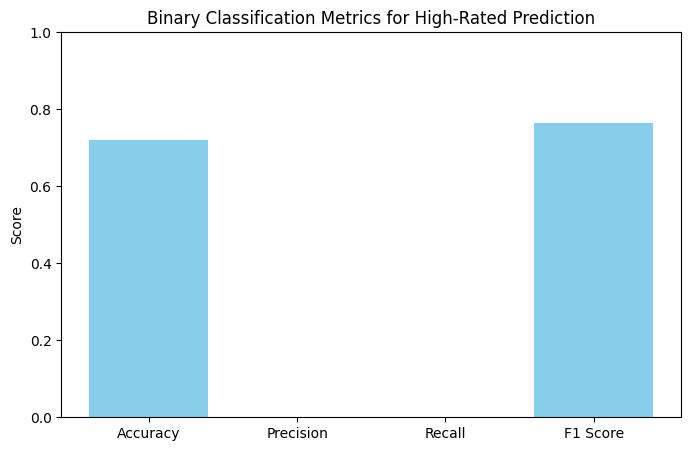

In [82]:
# Importing necessary libraries for visualization
import matplotlib.pyplot as plt

# Classification metrics visualization
classification_metrics = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
}

# Plotting the metrics as a bar chart
plt.figure(figsize=(8, 5))
plt.bar(classification_metrics.keys(), classification_metrics.values(), color='skyblue')
plt.title("Binary Classification Metrics for High-Rated Prediction")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()


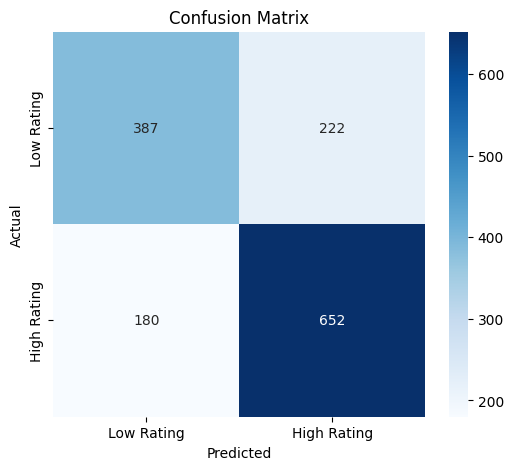

In [92]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculating confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_binary)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Low Rating", "High Rating"], yticklabels=["Low Rating", "High Rating"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Linear regression



In [65]:
# Importing dependencies
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import difflib

# Loading the data from the CSV file to a pandas dataframe
movies_data = pd.read_csv('/content/movies.csv')

# Selecting the relevant features for recommendation
selected_features = ['genres', 'keywords', 'tagline', 'cast', 'director']

# Replacing null values with an empty string
for feature in selected_features:
    movies_data[feature] = movies_data[feature].fillna('')

# Combining all the selected features into a single 'tags' column
movies_data['tags'] = movies_data['genres'] + ' ' + movies_data['keywords'] + ' ' + movies_data['tagline'] + ' ' + movies_data['cast'] + ' ' + movies_data['director']

# Selecting numeric features for score prediction
numeric_features = ['popularity', 'budget', 'runtime', 'vote_count', 'revenue']

# Ensuring no NaN values in numeric columns
movies_data[numeric_features] = movies_data[numeric_features].fillna(0)

# Splitting the dataset into training and testing sets for prediction
X_train, X_test, y_train, y_test = train_test_split(movies_data[numeric_features], movies_data['vote_average'], test_size=0.3, random_state=42)

# Initializing the Linear Regression model
linear_model = LinearRegression()

# Training the linear model on the numeric features to predict movie scores
linear_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = linear_model.predict(X_test)

# Evaluating the model with various metrics
print("Model Evaluation Metrics:")
print("R-squared:", r2_score(y_test, y_pred))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", mean_squared_error(y_test, y_pred, squared=False))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))

# Converting the 'tags' text data to feature vectors for similarity matching
vectorizer = TfidfVectorizer()
feature_vectors = vectorizer.fit_transform(movies_data['tags'])

# Calculating cosine similarity based on the feature vectors
similarity = cosine_similarity(feature_vectors)

# Function to recommend movies based on Linear Regression score prediction and cosine similarity
def get_movie_recommendations(movie_name, num_recommendations=10):
    # List of all movie titles
    list_of_all_titles = movies_data['title'].tolist()

    # Finding the closest match for the given movie title
    close_match = difflib.get_close_matches(movie_name, list_of_all_titles, n=1)

    if not close_match:
        return "Sorry, we couldn't find a match for your movie."

    close_match = close_match[0]
    movie_index = movies_data[movies_data.title == close_match].index[0]

    # Predicting the score of the input movie based on the Linear Regression model
    score_prediction = linear_model.predict([movies_data.loc[movie_index, numeric_features].values])
    print(f"Predicted score for '{close_match}': {score_prediction[0]:.2f}")

    # Finding similar movies based on cosine similarity
    distances = list(enumerate(similarity[movie_index]))
    sorted_similar_movies = sorted(distances, key=lambda x: x[1], reverse=True)

    # Displaying the recommended movies
    print(f"\nMovies recommended for you based on '{close_match}':\n")
    recommended_movies = []

    for i in sorted_similar_movies[1:num_recommendations + 1]:
        index = i[0]
        recommended_movies.append(movies_data['title'][index])

    return recommended_movies

# Example usage:
movie_name = input("Enter your favorite movie name: ")
recommended_movies = get_movie_recommendations(movie_name)

if isinstance(recommended_movies, list):
    for i, title in enumerate(recommended_movies, start=1):
        print(f"{i}. {title}")
else:
    print(recommended_movies)


Model Evaluation Metrics:
R-squared: 0.2526029361364218
Mean Absolute Error (MAE): 0.6867778232085646
Root Mean Squared Error (RMSE): 1.0402184755755783
Mean Squared Error (MSE): 1.08205447692878


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Enter your favorite movie name: avengers
Predicted score for 'The Avengers': 9.03

Movies recommended for you based on 'The Avengers':

1. Thor
2. Avengers: Age of Ultron
3. Captain America: The Winter Soldier
4. The Dark Knight Rises
5. Iron Man 2
6. Thor: The Dark World
7. Iron Man 3
8. Captain America: Civil War
9. Sin City
10. Star Trek


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


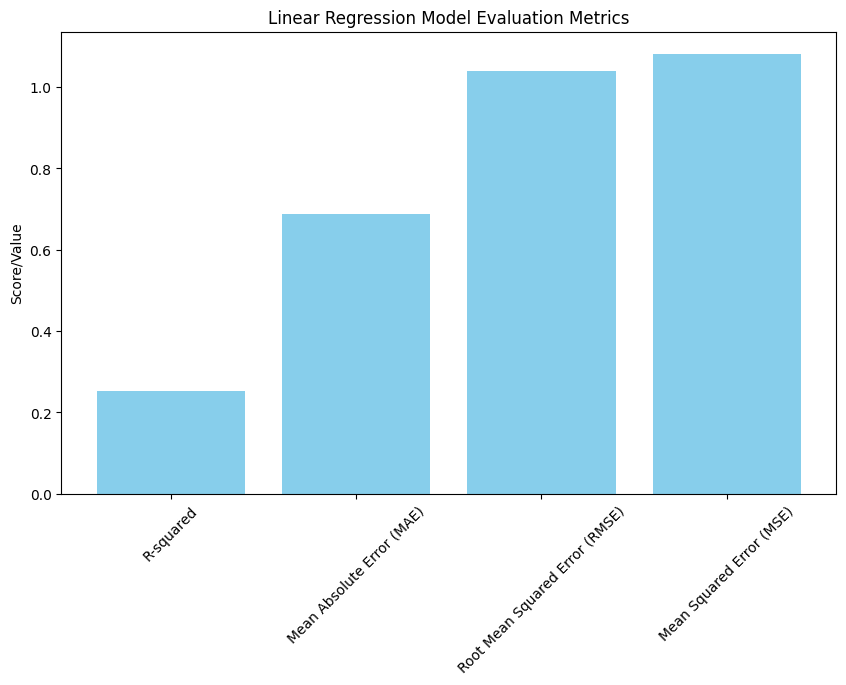

In [79]:
import matplotlib.pyplot as plt

# Model Evaluation Metrics Visualization
metrics = {
    "R-squared": r2_score(y_test, y_pred),
    "Mean Absolute Error (MAE)": mean_absolute_error(y_test, y_pred),
    "Root Mean Squared Error (RMSE)": mean_squared_error(y_test, y_pred, squared=False),
    "Mean Squared Error (MSE)": mean_squared_error(y_test, y_pred)
}

# Plotting the metrics
plt.figure(figsize=(10, 6))
plt.bar(metrics.keys(), metrics.values(), color='skyblue')
plt.title("Linear Regression Model Evaluation Metrics")
plt.ylabel("Score/Value")
plt.xticks(rotation=45)
plt.show()


Enter your favorite movie name: avengers
Movies recommended for you based on 'The Avengers':



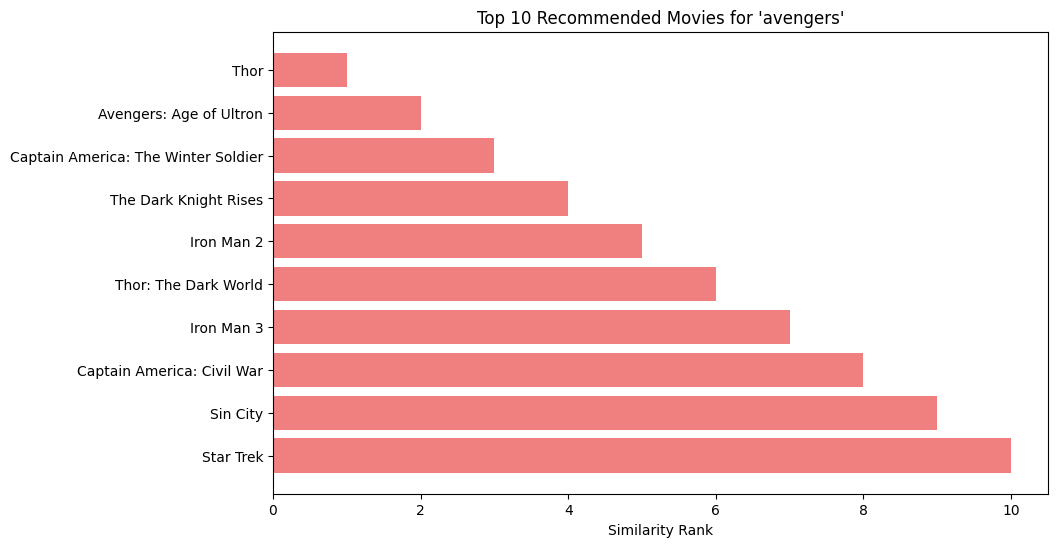

In [81]:
# Function to plot the top recommended movies bar chart
def plot_top_recommendations(movie_name, num_recommendations=10):
    recommended_movies = get_movie_recommendations(movie_name, num_recommendations)

    if isinstance(recommended_movies, list):
        plt.figure(figsize=(10, 6))
        plt.barh(recommended_movies, range(1, num_recommendations+1), color='lightcoral')
        plt.xlabel('Similarity Rank')
        plt.title(f"Top {num_recommendations} Recommended Movies for '{movie_name}'")
        plt.gca().invert_yaxis()  # Invert the y-axis to show the top recommendation first
        plt.show()
    else:
        print(recommended_movies)

# Example usage to plot recommended movies
movie_name = input("Enter your favorite movie name: ")
plot_top_recommendations(movie_name)
